In [2]:
import librosa
import torch
import glob
import tqdm
import os

In [4]:
data_path = '/dfs/user/prabhat8/CS224S/gad'

In [21]:
lengths = []
for wav in tqdm.tqdm(glob.glob(f"{data_path}/*.wav")):
    lengths.append(librosa.get_duration(filename=wav))

100%|██████████| 2257/2257 [00:29<00:00, 76.59it/s] 


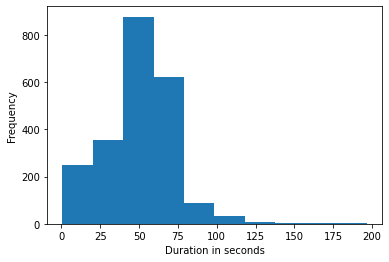

In [28]:
import matplotlib.pyplot as plt
import numpy as np
l = np.array(lengths)
l = l[l <=200]
plt.hist(l)
plt.xlabel('Duration in seconds')
plt.ylabel('Frequency')
plt.savefig('duration.pdf')
# plt.xlim((-1, 200))

In [3]:

from transformers import Wav2Vec2Tokenizer, Wav2Vec2ForCTC

# load pretrained model
tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")
model = model
wav2transcript = {}
for wav in tqdm.tqdm(glob.glob(f"{data_path}/*.wav")):
    fname = os.path.basename(wav)[:-4] + ".txt"
    if os.path.exists(os.path.join(data_path, 'transcripts', fname)):
        continue
    # load audio
    audio_input, sr = librosa.load(wav, sr=16000)
    try:
        input_values = tokenizer(audio_input, return_tensors="pt", padding="longest").input_values
        if len(audio_input) > 16000*2*60:
            vals = torch.chunk(input_values, len(audio_input) // (16000*2*60) + 1, dim=-1)
            print(len(vals))
        else:
            vals = [input_values]
        transcription = ''
        for input_val in vals:
            logits = model(input_val).logits
            predicted_ids = torch.argmax(logits, dim=-1)
            transcription += tokenizer.batch_decode(predicted_ids)[0]
        print(transcription, wav)
        with open(os.path.join(data_path, 'transcripts', fname), 'w') as f:
            f.write(transcription)
    except Exception as e:
        print(e, wav, len(audio_input))

100%|██████████| 2257/2257 [00:00<00:00, 100097.75it/s]


In [5]:
paths = glob.glob(f"{data_path}/transcripts/*.txt")

In [19]:
import random
path = random.choice(paths)
with open(os.path.join(path)) as f:
    s = f.readlines()[0]
s.capitalize()

"I feel eh but lest less and demotivated there's lot of work that i need to do and i folting the ent on my responsibility is at work sometimes i think in my personal life as well is also just general diredness i feel like have got enough sleep or haven't got nough exercise so just feeling bored and dem otivated o"

In [17]:
from transformers import AutoTokenizer, AutoModelWithLMHead

tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-emotion")

model = AutoModelWithLMHead.from_pretrained("mrm8488/t5-base-finetuned-emotion")


In [15]:
def get_emotion(text):
    input_ids = tokenizer.encode(text + '</s>', return_tensors='pt')

    output = model.generate(input_ids=input_ids,
               max_length=5)

    dec = [tokenizer.decode(ids) for ids in output]
    label = dec[0]
    return label

In [16]:
get_emotion("i have a feeling i kinda lost my best friend")

'<pad> sadness</s>'

In [17]:
get_emotion("i feel as if i havent blogged in ages are at least truly blogged i am doing an update cute")

'<pad> joy</s>'

In [31]:
data_path = '/dfs/user/prabhat8/CS224S/gad'
t2emotion = {}
for t in os.listdir(os.path.join(data_path, 'transcripts')):
    with open(os.path.join(data_path, 'transcripts', t)) as f:
        text = f.readlines()
#         print(text)
    if len(text) == 0:
        continue
    e = get_emotion(text[0])
    try:
        t2emotion[t] = e[5:-4].strip()
    except:
        print(e)

In [35]:
import pickle
with open('/dfs/user/prabhat8/CS224S/emotion.pkl', 'wb') as f:
    pickle.dump(t2emotion, f)

In [36]:
from transformers import AutoTokenizer, AutoModelWithLMHead

tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-imdb-sentiment")

model = AutoModelWithLMHead.from_pretrained("mrm8488/t5-base-finetuned-imdb-sentiment")

def get_sentiment(text):
    input_ids = tokenizer.encode(text + '</s>', return_tensors='pt')

    output = model.generate(input_ids=input_ids,
               max_length=5)

    dec = [tokenizer.decode(ids) for ids in output]
    label = dec[0]
    return label

get_sentiment("I dislike a lot that film")

'<pad> negative</s>'

In [38]:
data_path = '/dfs/user/prabhat8/CS224S/gad'
t2sentiment = {}
for t in tqdm.tqdm(os.listdir(os.path.join(data_path, 'transcripts'))):
    with open(os.path.join(data_path, 'transcripts', t)) as f:
        text = f.readlines()
#         print(text)
    if len(text) == 0:
        continue
    e = get_sentiment(text[0])
    try:
        t2sentiment[t] = e[5:-4].strip()
    except:
        print(e)

100%|██████████| 2257/2257 [05:51<00:00,  6.42it/s]


In [40]:
import pickle
with open('/dfs/user/prabhat8/CS224S/sentiment.pkl', 'wb') as f:
    pickle.dump(t2sentiment, f)

In [56]:
import pandas as pd
labels = pd.read_csv(os.path.join(data_path, 'data.csv'), header=0)
print(labels.head(2))
labels = labels.drop_duplicates('filename').set_index('filename')
labels.shape

     dataset                                               user  score  \
0   Kintsugi                       2HIcyskm7YOYF1sYZkNr0d1pYoj2    5.0   
1  Phonic3-2  6012ffda61fde9a427efe695questions6012ffda61fde...   10.0   

   bucketed_score                                           filename  \
0               0                           gTqHOGwSDEirT9x8HN2T.wav   
1               1  6012ffda61fde9a427efe695questions6012ffda61fde...   

    duration  
0  28.643356  
1  63.146667  


(2257, 5)

In [69]:
labels['emotion'] = labels.index.map(lambda x: t2emotion.get(x[:-3]+'txt', 'Not Found'))
labels['sentiment'] = labels.index.map(lambda x: t2sentiment.get(x[:-3]+'txt', 'Not Found'))

In [72]:
labels.bucketed_score.value_counts()

0    1162
1     529
2     335
3     231
Name: bucketed_score, dtype: int64

In [70]:
labels.emotion.value_counts()

joy          1695
sadness       292
anger         144
Not Found      69
fear           54
love            2
OR              1
Name: emotion, dtype: int64

In [112]:
labels['anxiety'] = labels['bucketed_score'] > 0

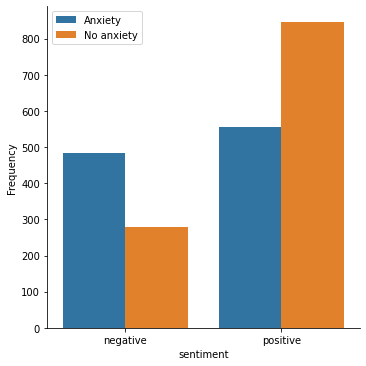

In [141]:
sen_vals = ['positive', 'negative']
import seaborn as sns
data = labels[labels.sentiment.isin(sen_vals)].groupby(['sentiment', 'anxiety_label'])['score'].count().reset_index()
g = sns.catplot(x="sentiment", y="score", hue="anxiety_label", data=data, kind='bar', legend_out=False)
# g.despine(left=True)
plt.ylabel('Frequency')
plt.gca().get_legend().set_title('')

plt.savefig('sentiment.pdf')
# plt.ylabel('Frequency')
# plt.xticks([0, 1], ['No anxiety', 'Anxiety'])

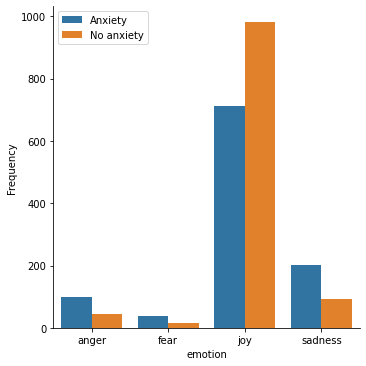

In [140]:
emo_vals = ['joy', 'sadness', 'anger', 'fear']
import seaborn as sns
labels['anxiety_label'] = labels['anxiety'].map(lambda x: 'Anxiety' if x else 'No anxiety')
data = labels[labels.emotion.isin(emo_vals)].groupby(['emotion', 'anxiety_label'])['score'].count().reset_index()
g = sns.catplot(x="emotion", y="score", hue="anxiety_label", data=data, kind='bar', legend_out=False)
# g.despine(left=True)
plt.ylabel('Frequency')
plt.gca().get_legend().set_title('')
plt.savefig('emotion.pdf')
#plt.xticks([0, 1], ['No anxiety', 'Anxiety'])

In [84]:
import matplotlib.pyplot as plt
import numpy as np
pos = []
neg = []
for i in range(4):
    pos.append((labels[labels.bucketed_score == i].sentiment == 'positive').sum())
    neg.append((labels[labels.bucketed_score == i].sentiment == 'negative').sum())
pos, neg = np.array(pos), np.array(neg)

<BarContainer object of 4 artists>

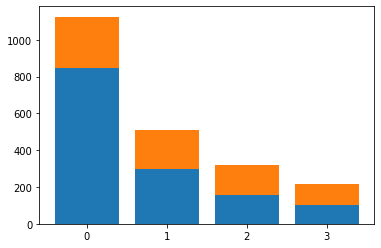

In [90]:
plt.bar(list(map(str, range(4))), pos)
plt.bar(list(map(str, range(4))), neg, bottom=pos, label='negative')